In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set the root paths (update these to your local paths)
input_root = '/home/msiau/data/tmp/agarciat/DIV2K'
output_root = '/home/msiau/data/tmp/agarciat/DIV2K_processed'

# HR patch size (Height, Width)
hr_patch_size = (144, 144)  # You can change this value as needed

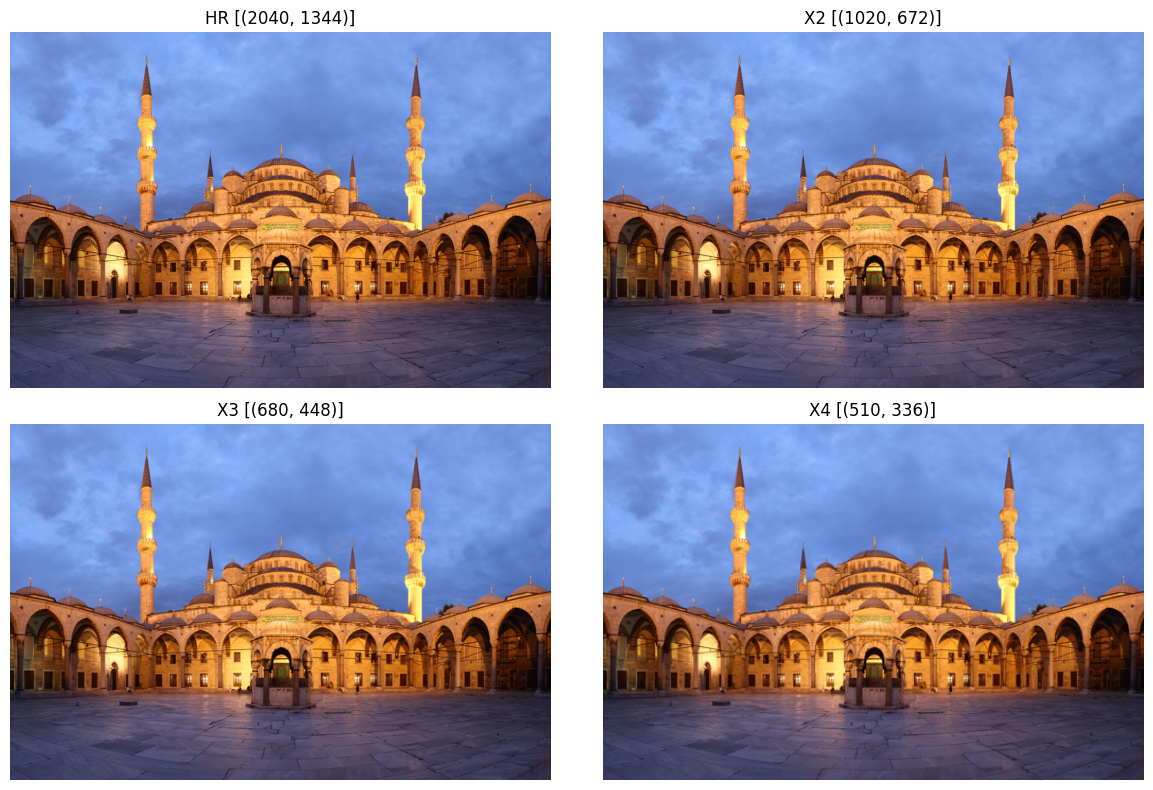

In [2]:
def display_random_images():
    # Select a random HR image from the training HR folder.
    hr_dir = os.path.join(input_root, 'DIV2K_train_HR')
    filenames = [f for f in os.listdir(hr_dir) if f.endswith('.png') or f.endswith('.jpg')]
    random_file = random.choice(filenames)
    
    # Open the HR image.
    hr_img = Image.open(os.path.join(hr_dir, random_file))
    
    # Get the base name without extension for modifying LR filenames
    base_name = os.path.splitext(random_file)[0]
    
    # Open the corresponding LR images from the bicubic folder.
    lr2_path = os.path.join(input_root, 'DIV2K_train_LR_bicubic', 'X2', f"{base_name}x2.png")
    lr3_path = os.path.join(input_root, 'DIV2K_train_LR_bicubic', 'X3', f"{base_name}x3.png")
    lr4_path = os.path.join(input_root, 'DIV2K_train_LR_bicubic', 'X4', f"{base_name}x4.png")
    
    lr2_img = Image.open(lr2_path)
    lr3_img = Image.open(lr3_path)
    lr4_img = Image.open(lr4_path)
    
    # Plot the images in a 2x2 grid.
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(hr_img)
    plt.title(f'HR [{hr_img.size}]')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(lr2_img)
    plt.title(f'X2 [{lr2_img.size}]')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(lr3_img)
    plt.title(f'X3 [{lr3_img.size}]')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(lr4_img)
    plt.title(f'X4 [{lr4_img.size}]')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random images
display_random_images()

In [14]:
# Updated Cell 4: Patch Extraction Functions and Processing Loop with Divisibility, Padding, and Variance Considerations

from PIL import ImageOps
import numpy as np

def is_uniform_patch(patch, threshold=15.0):
    """
    Check if a patch is mostly a uniform color.
    Returns True if the patch is uniform (low variance), False otherwise.
    
    Args:
        patch: PIL Image patch
        threshold: Variance threshold below which patch is considered uniform
    """
    # Convert to numpy array
    patch_np = np.array(patch)
    
    # For grayscale images
    if len(patch_np.shape) == 2:
        std = np.std(patch_np)
        return std < threshold
    
    # For color images, check std across all channels
    std_per_channel = np.std(patch_np, axis=(0, 1))
    avg_std = np.mean(std_per_channel)
    return avg_std < threshold

def extract_and_save_patches(hr_image_path, lr_bicubic_paths, lr_unknown_paths,
                             out_hr_dir, out_lr_bicubic_dirs, out_lr_unknown_dirs,
                             patch_size, scale_factors=[2, 3, 4], pad_if_needed=False,
                             variance_threshold=15.0):
    """
    Extract patches from an HR image and the corresponding LR images for each scale.
    Two strategies are available:
      - If pad_if_needed=False (default): Only extract patches that fully fit into the image,
        discarding any border pixels that don't complete a full patch.
      - If pad_if_needed=True: Pad the HR image (and the LR images) so that the dimensions
        become an exact multiple of patch_size. Reflection padding is used.
      
    Patches that are mostly uniform color (like sky) are filtered out using variance threshold.
    """
    # Open HR image.
    hr_img = Image.open(hr_image_path)
    hr_width, hr_height = hr_img.size
    patch_h, patch_w = patch_size

    # Determine remainders to see if the HR image dimensions are divisible by patch_size.
    rem_w = hr_width % patch_w
    rem_h = hr_height % patch_h
    if pad_if_needed and (rem_w != 0 or rem_h != 0):
        # Compute required padding amounts.
        pad_right = (patch_w - rem_w) if rem_w != 0 else 0
        pad_bottom = (patch_h - rem_h) if rem_h != 0 else 0
        hr_img = ImageOps.expand(hr_img, border=(0, 0, pad_right, pad_bottom), fill='reflect')
        hr_width, hr_height = hr_img.size  # Update dimensions after padding.
    else:
        # Crop the image to only consider the complete patches.
        hr_width = hr_width - rem_w
        hr_height = hr_height - rem_h
        hr_img = hr_img.crop((0, 0, hr_width, hr_height))

    num_patches = 0
    # Slide a window over the HR image to extract patches.
    for top in range(0, hr_height, patch_h):
        for left in range(0, hr_width, patch_w):
            # Extract HR patch.
            hr_patch = hr_img.crop((left, top, left + patch_w, top + patch_h))
            
            # Skip uniform patches (like sky, plain backgrounds)
            if is_uniform_patch(hr_patch, threshold=variance_threshold):
                continue
                
            base_name = os.path.splitext(os.path.basename(hr_image_path))[0]
            patch_filename = f"{base_name}_patch_{num_patches}.png"
            hr_patch.save(os.path.join(out_hr_dir, patch_filename))
            
            # For each scale factor, compute and save the corresponding LR patch.
            for scale in scale_factors:
                lr_patch_w = patch_w // scale
                lr_patch_h = patch_h // scale
                
                # Process LR bicubic image.
                lr_bicubic_img = Image.open(lr_bicubic_paths[scale])
                lr_width, lr_height = lr_bicubic_img.size
                lr_rem_w = lr_width % lr_patch_w
                lr_rem_h = lr_height % lr_patch_h
                if pad_if_needed and (lr_rem_w != 0 or lr_rem_h != 0):
                    lr_pad_right = (lr_patch_w - lr_rem_w) if lr_rem_w != 0 else 0
                    lr_pad_bottom = (lr_patch_h - lr_rem_h) if lr_rem_h != 0 else 0
                    lr_bicubic_img = ImageOps.expand(lr_bicubic_img, border=(0, 0, lr_pad_right, lr_pad_bottom), fill='reflect')
                    lr_width, lr_height = lr_bicubic_img.size
                else:
                    lr_bicubic_img = lr_bicubic_img.crop((0, 0, lr_width - lr_rem_w, lr_height - lr_rem_h))
                
                # Compute corresponding coordinates in the LR image.
                lr_left = left // scale
                lr_top = top // scale
                lr_bicubic_patch = lr_bicubic_img.crop((lr_left, lr_top, lr_left + lr_patch_w, lr_top + lr_patch_h))
                lr_bicubic_patch.save(os.path.join(out_lr_bicubic_dirs[scale], patch_filename))
                
                # Process LR unknown image similarly.
                lr_unknown_img = Image.open(lr_unknown_paths[scale])
                lr_width, lr_height = lr_unknown_img.size
                lr_rem_w = lr_width % lr_patch_w
                lr_rem_h = lr_height % lr_patch_h
                if pad_if_needed and (lr_rem_w != 0 or lr_rem_h != 0):
                    lr_pad_right = (lr_patch_w - lr_rem_w) if lr_rem_w != 0 else 0
                    lr_pad_bottom = (lr_patch_h - lr_rem_h) if lr_rem_h != 0 else 0
                    lr_unknown_img = ImageOps.expand(lr_unknown_img, border=(0, 0, lr_pad_right, lr_pad_bottom), fill='reflect')
                    lr_width, lr_height = lr_unknown_img.size
                else:
                    lr_unknown_img = lr_unknown_img.crop((0, 0, lr_width - lr_rem_w, lr_height - lr_rem_h))
                
                lr_unknown_patch = lr_unknown_img.crop((lr_left, lr_top, lr_left + lr_patch_w, lr_top + lr_patch_h))
                lr_unknown_patch.save(os.path.join(out_lr_unknown_dirs[scale], patch_filename))
            
            num_patches += 1

def process_dataset(dataset_type='train', pad_if_needed=False, variance_threshold=15.0):
    """
    Process the dataset (train or valid) by extracting patches.
    The corresponding LR images (bicubic and unknown) are handled for each scale.
    Patches with low variance (uniform color) are filtered out.
    """
    print(f"Processing {dataset_type} dataset with pad_if_needed={pad_if_needed}, variance_threshold={variance_threshold}...")
    
    # Input directories.
    hr_dir = os.path.join(input_root, f'DIV2K_{dataset_type}_HR')
    lr_bicubic_dir = os.path.join(input_root, f'DIV2K_{dataset_type}_LR_bicubic')
    lr_unknown_dir = os.path.join(input_root, f'DIV2K_{dataset_type}_LR_unknown')
    
    # Output directories.
    out_hr_dir = os.path.join(output_root, f'DIV2K_{dataset_type}_HR')
    out_lr_bicubic_dirs = {scale: os.path.join(output_root, f'DIV2K_{dataset_type}_LR_bicubic', f'X{scale}')
                           for scale in [2, 3, 4]}
    out_lr_unknown_dirs = {scale: os.path.join(output_root, f'DIV2K_{dataset_type}_LR_unknown', f'X{scale}')
                           for scale in [2, 3, 4]}
    
    # Process each HR image.
    for img_file in sorted(os.listdir(hr_dir)):
        if not (img_file.endswith('.png') or img_file.endswith('.jpg')):
            continue
        hr_image_path = os.path.join(hr_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        lr_bicubic_paths = {scale: os.path.join(lr_bicubic_dir, f'X{scale}', f"{base_name}x{scale}.png")
                            for scale in [2, 3, 4]}
        lr_unknown_paths = {scale: os.path.join(lr_unknown_dir, f'X{scale}', f"{base_name}x{scale}.png")
                            for scale in [2, 3, 4]}
        
        extract_and_save_patches(hr_image_path, lr_bicubic_paths, lr_unknown_paths,
                                 out_hr_dir, out_lr_bicubic_dirs, out_lr_unknown_dirs,
                                 patch_size=hr_patch_size, pad_if_needed=pad_if_needed,
                                 variance_threshold=variance_threshold)
        print(f"Processed {img_file}")

# Process both the training and validation sets.
# Set pad_if_needed to True if you want to pad images to cover the entire area,
# or leave it as False to discard border regions that don't form a full patch.
#process_dataset('train', pad_if_needed=False, variance_threshold=15.0)
process_dataset('valid', pad_if_needed=False, variance_threshold=15.0)

Processing valid dataset with pad_if_needed=False, variance_threshold=15.0...
Processed 0801.png
Processed 0802.png
Processed 0803.png
Processed 0804.png
Processed 0805.png
Processed 0806.png
Processed 0807.png
Processed 0808.png
Processed 0809.png
Processed 0810.png
Processed 0811.png
Processed 0812.png
Processed 0813.png
Processed 0814.png
Processed 0815.png
Processed 0816.png
Processed 0817.png
Processed 0818.png
Processed 0819.png
Processed 0820.png
Processed 0821.png
Processed 0822.png
Processed 0823.png
Processed 0824.png
Processed 0825.png
Processed 0826.png
Processed 0827.png
Processed 0828.png
Processed 0829.png
Processed 0830.png
Processed 0831.png
Processed 0832.png
Processed 0833.png
Processed 0834.png
Processed 0835.png
Processed 0836.png
Processed 0837.png
Processed 0838.png
Processed 0839.png
Processed 0840.png
Processed 0841.png
Processed 0842.png
Processed 0843.png
Processed 0844.png
Processed 0845.png
Processed 0846.png
Processed 0847.png
Processed 0848.png
Processed 

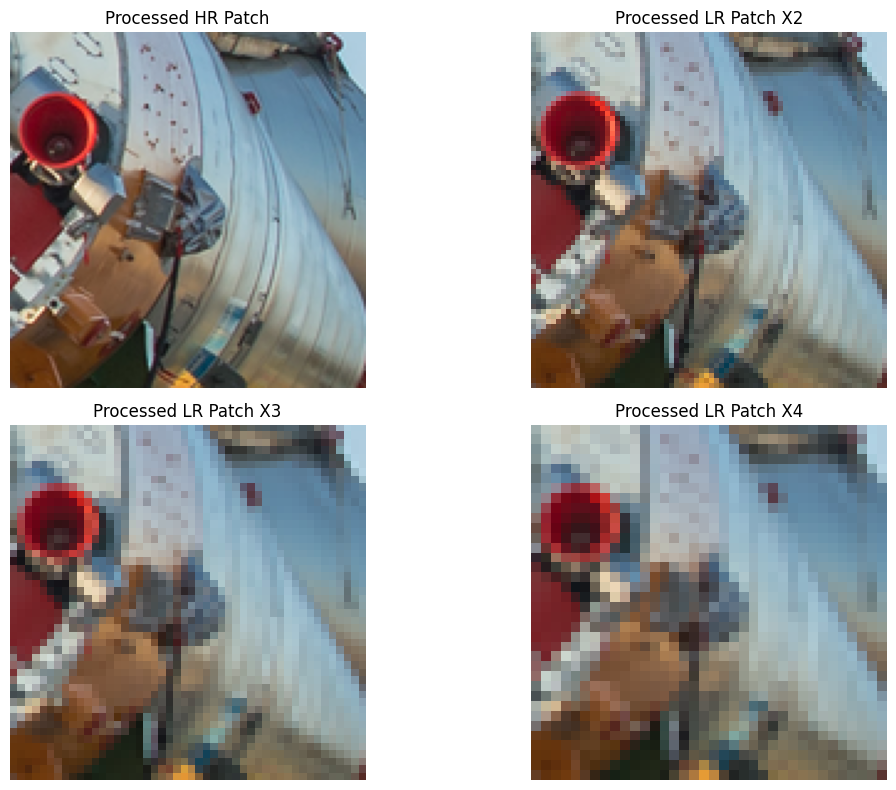

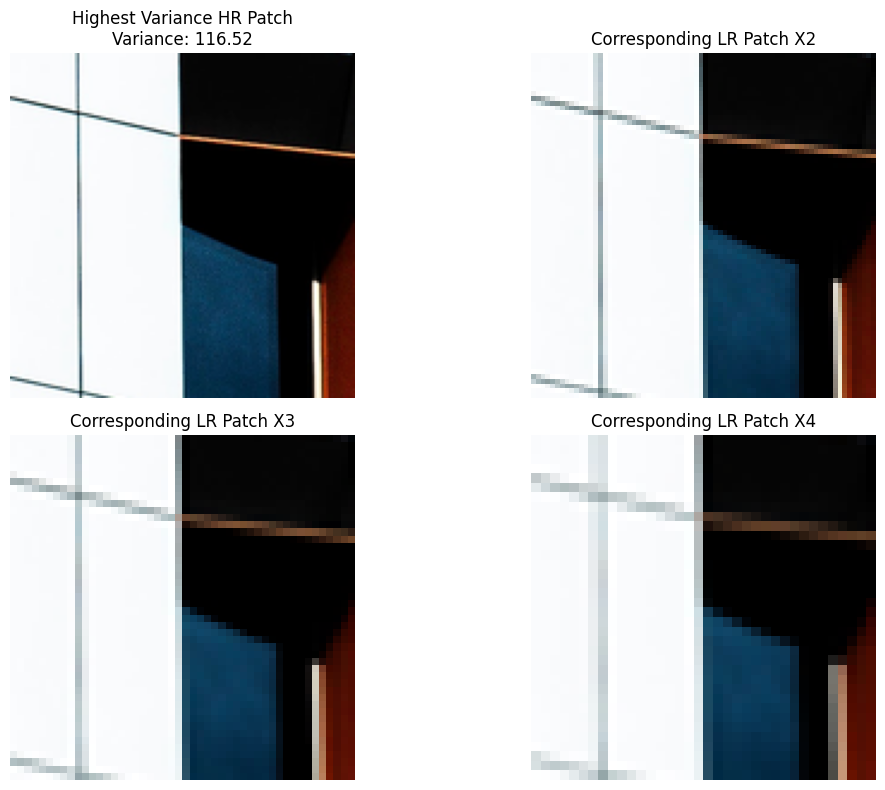

In [3]:
def display_random_processed_patches():
    # Select a random processed HR patch from the output train HR folder.
    processed_hr_dir = os.path.join(output_root, 'DIV2K_train_HR')
    filenames = [f for f in os.listdir(processed_hr_dir) if f.endswith('.png') or f.endswith('.jpg')]
    if not filenames:
        print("No processed patches found in:", processed_hr_dir)
        return
    random_file = random.choice(filenames)
    
    # Open the processed HR patch.
    hr_patch = Image.open(os.path.join(processed_hr_dir, random_file))
    
    # Open the corresponding LR patches from the LR_bicubic folders.
    lr2_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X2', random_file))
    lr3_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X3', random_file))
    lr4_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X4', random_file))
    
    # Plot the patches in a 2x2 grid.
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(hr_patch)
    plt.title('Processed HR Patch')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(lr2_patch)
    plt.title('Processed LR Patch X2')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(lr3_patch)
    plt.title('Processed LR Patch X3')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(lr4_patch)
    plt.title('Processed LR Patch X4')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_image_variance(img):
    """
    Calculate the variance of an image to measure color variation.
    Higher values indicate more variation/detail in the image.
    """
    # Convert to numpy array
    img_np = np.array(img)
    
    # For grayscale images
    if len(img_np.shape) == 2:
        return np.std(img_np)
    
    # For color images, calculate std across all channels
    std_per_channel = np.std(img_np, axis=(0, 1))
    return np.mean(std_per_channel)

def display_highest_variance_patches():
    """
    Display the processed HR patch with the highest variance (most detail/color variation)
    along with its corresponding LR patches.
    """
    # Get all processed HR patches
    processed_hr_dir = os.path.join(output_root, 'DIV2K_train_HR')
    filenames = [f for f in os.listdir(processed_hr_dir) if f.endswith('.png') or f.endswith('.jpg')]
    if not filenames:
        print("No processed patches found in:", processed_hr_dir)
        return
    
    # Calculate variance for each patch
    variance_scores = []
    for filename in filenames:
        hr_patch = Image.open(os.path.join(processed_hr_dir, filename))
        variance = calculate_image_variance(hr_patch)
        variance_scores.append((filename, variance))
    
    # Sort by variance (highest first)
    variance_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Get the filename with highest variance
    highest_variance_file = variance_scores[0][0]
    
    # Open the HR patch with highest variance
    hr_patch = Image.open(os.path.join(processed_hr_dir, highest_variance_file))
    
    # Open the corresponding LR patches
    lr2_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X2', highest_variance_file))
    lr3_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X3', highest_variance_file))
    lr4_patch = Image.open(os.path.join(output_root, 'DIV2K_train_LR_bicubic', 'X4', highest_variance_file))
    
    # Plot the patches in a 2x2 grid
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(hr_patch)
    plt.title(f'Highest Variance HR Patch\nVariance: {variance_scores[0][1]:.2f}')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(lr2_patch)
    plt.title('Corresponding LR Patch X2')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(lr3_patch)
    plt.title('Corresponding LR Patch X3')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(lr4_patch)
    plt.title('Corresponding LR Patch X4')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random processed patches
display_random_processed_patches()

# Display the patch with highest color variation
display_highest_variance_patches()
